## Do You Want To Play A Game?

# Overview

Of course you do, but as any gamer knows, there are so many choices. Our company, (Insert Here), was tasked with creating a recommendation system in order to solve this problem for all the gamers out there.

# Business Understanding

The video game industry is currently worth $214 billion. More money than you or I could ever even dream of seeing, to put it another way. Therefore, the ability to accurately recommend games to users that will purchase them (thereby making a company more money) is a real, wait for it, game-changer. That is exactly what (Insert Here) was tasked with - create a recommendation system that accurately recommends games to users based on established ratings.

# Data Understanding

In [2]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

Our data comes to us from Kaggle, and is publicly available user data from Steam, a PC video game client. There are many other similar clients, such as Epic, The EA App (formerly Origin) and Battle.net for Overwatch. Therefore, some large games such as Fortnite and, as mentioned, Overwatch, will not be included in this data and that must be kept in mind as we begin the process of exploring our data and building a recommendation system.

In [3]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [4]:
steam_df.head(25)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


We have made our data into a dataframe that is comprised of five columns, "UserID", "Game" (or Title), "Action" (Play/Purchase in this case), "Hours" (as in Hours Played), and "Other".

In [5]:
steam_df.value_counts()

UserID     Game                                          Action    Hours  Other
93275329   Grand Theft Auto Vice City                    purchase  1.0    0        2
116876958  Grand Theft Auto III                          purchase  1.0    0        2
27169419   Sid Meier's Civilization IV Beyond the Sword  purchase  1.0    0        2
           Sid Meier's Civilization IV                   purchase  1.0    0        2
46028967   Sid Meier's Civilization IV                   purchase  1.0    0        2
                                                                                  ..
127072755  Mortal Kombat Komplete Edition                purchase  1.0    0        1
                                                         play      0.3    0        1
           Just Cause 2 Multiplayer Mod                  purchase  1.0    0        1
                                                         play      0.7    0        1
5250       Alien Swarm                                   play      4.9

A quick .value_counts() shows us that each title is repeated once for play and purchase, respectively, along with other important information. "Other", in this case, seems to be entirely useless to us, and whether a game was purchased or not did not seem to have much of an impact on hours played, so we decided to drop both of those.

# Data Preparation

In [6]:
play_data = steam_df[steam_df['Action'] == 'play']

In [7]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

In [8]:
play_data_new.head()

,UserID,Game,Hours
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


As we can see, the dataframe has now been trimmed down to simply "UserID", "Game" and "Hours".

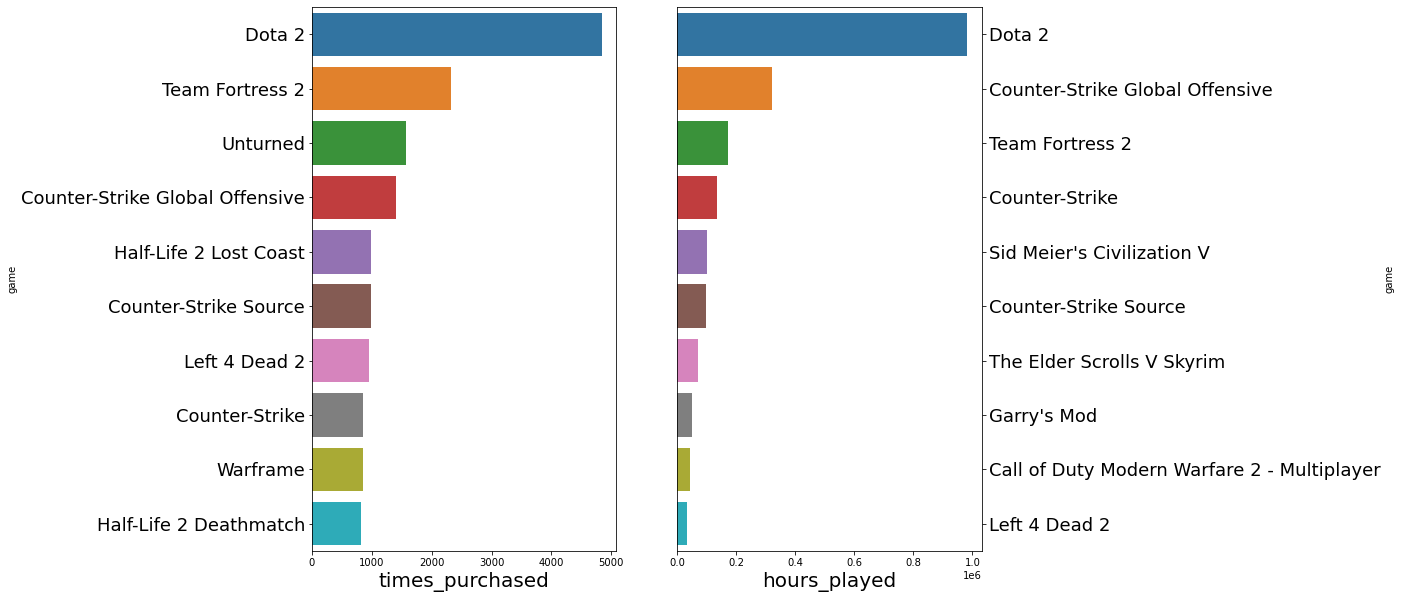

In [9]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

The above plot shows visually our reason for simply removing the "purchase" column; when comparing hours_played to times_purchased, the games do not correlate, and so it does not seem to be relevant to the recommendation process. Thus, we have removed that variable.

In [10]:
game_hours_min_max = play_data_new.groupby('Game')['Hours'].agg(['min', 'max']).reset_index()

In [11]:
game_hours_min_max.columns = ['Game', 'Min_Hours', 'Max_Hours']

play_data_agg_min_max = play_data_new.merge(game_hours_min_max, on='Game')

play_data_agg_min_max.head()

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0


In the preceding cells, we've written a function for cumulative hours to fit a rating system, and recalculated the total hours played for each game across all users. Finally, we've created a dataframe from that information and combined it with the original dataframe so that we have at our fingertips the minimum and maximum hours played for each video game listed.

In [12]:
play_data_agg_min_max.tail(25)

,UserID,Game,Hours,Min_Hours,Max_Hours
70464,60859695,Fire,3.1,3.1,3.1
70465,60859695,Kuros,2.5,2.5,2.5
70466,60859695,Back to Bed,1.6,1.6,1.6
70467,60859695,Nancy Drew The Creature of Kapu Cave,1.6,1.6,1.6
70468,60859695,Legend of Fae,0.3,0.3,0.3
70469,75970863,Hotel Dash,9.0,9.0,9.0
70470,75970863,Diner Dash Hometown Hero,5.1,5.1,5.1
70471,75970863,DinerTown Tycoon,1.0,1.0,1.0
70472,42657809,Worldwide Soccer Manager 2009,295.0,295.0,295.0
70473,42657809,MLB 2K10,228.0,228.0,228.0


A quick .tail() exploration allows us to see that the function is working as intended and returning the proper information.

In [13]:
filtered_data = play_data_agg_min_max.loc[play_data_agg_min_max['Min_Hours'] != play_data_agg_min_max['Max_Hours']]

In [14]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0
...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5


Now, we've grouped our data by the hours played of each game. Our next step is to create a rating system based on hours played and add that column and information to the dataframe as well.

In [15]:
def ratings_normalize(d):
    new_series = d['Hours'] / d['Max_Hours']
    return new_series

In [16]:
filtered_data['Hours']

0        273.0
1         58.0
2        110.0
3        465.0
4        220.0
         ...  
70424      5.9
70436      1.3
70437      0.8
70438      0.5
70439      0.2
Name: Hours, Length: 69432, dtype: float64

In [17]:
filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)

<ipython-input-17-aef263175d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)


In [18]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0,0.137462
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0,0.029204
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0,0.055388
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0,0.234139
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0,0.110775
...,...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9,1.000000
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3,1.000000
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3,0.615385
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5,1.000000


In [19]:
filtered_data_new = pd.read_csv('./data/filtered_steam_games.csv', index_col=[0])

Now, we have a rudimentary rating system based on hours played per game in our dataset, and we can begin the process of analyzing our data and building a recommendation system in order to accurately predict which games customers will enjoy based on a game's "rating".

# Analysis

First, we will need a baseline. In other words, somewhere to begin in order to accurately predict a customer's taste.

In [20]:
from surprise import Dataset, Reader, NormalPredictor
from surprise.model_selection import cross_validate

# Prepare the data for Surprise
reader = Reader(rating_scale=(filtered_data_new['Ratings'].min(), filtered_data_new['Ratings'].max()))
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# Define the NormalPredictor model
algo = NormalPredictor()

# Perform cross-validation and compute RMSE
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2943  0.2922  0.2974  0.2959  0.2938  0.2947  0.0018  
Fit time          0.12    0.14    0.15    0.14    0.15    0.14    0.01    
Test time         0.14    0.22    0.15    0.21    0.14    0.17    0.04    
Average RMSE using NormalPredictor: 0.2947198340976036


Once we have our baseline results, it is time to iterate again with a different method and see if perhaps we can improve upon those results. Below, we have used the SVD method and plotted the results to make them more easily comprehensible.

In [21]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# SVD algo
algo_svd = SVD()

# Perform cross-validation
svd_results = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2136  0.2176  0.2128  0.2174  0.2140  0.2151  0.0020  
MAE (testset)     0.1256  0.1272  0.1248  0.1264  0.1255  0.1259  0.0008  
Fit time          4.00    3.94    4.00    3.93    3.94    3.96    0.03    
Test time         0.22    0.14    0.22    0.14    0.22    0.19    0.04    


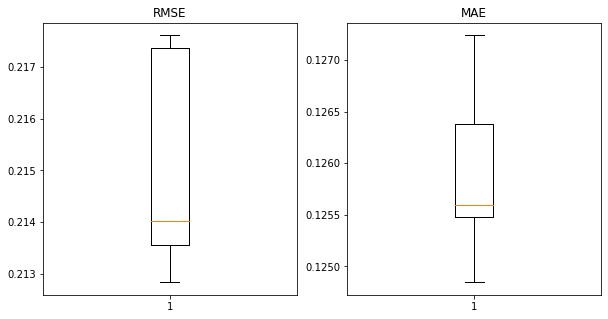

In [22]:
rmse = svd_results['test_rmse']
mae = svd_results['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

Another iteration, with another change and another box plot to show the difference in results.

In [23]:
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2256  0.2303  0.2300  0.2241  0.2231  0.2266  0.0030  
MAE (testset)     0.1380  0.1389  0.1395  0.1354  0.1347  0.1373  0.0019  
Fit time          24.76   23.13   23.25   23.36   23.45   23.59   0.60    
Test time         4.16    4.17    4.33    4.21    4.34    4.24    0.08    


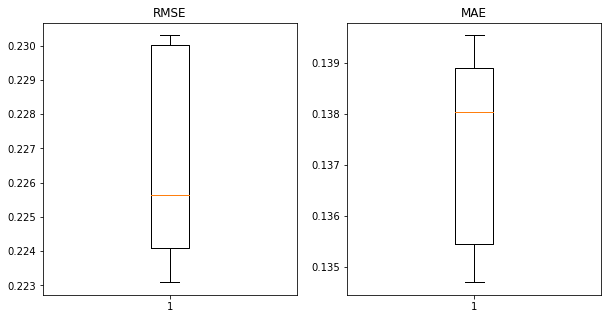

In [24]:
rmse = results_knnm['test_rmse']
mae = results_knnm['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

Now, we will do a grid search to run through each model iteration so far and find the best parameters for our purposes.

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

# Load your dataset
dataset = pd.read_csv('./data/filtered_steam_games.csv')

# Prepare the data for Surprise
reader = Reader(rating_scale=(dataset['Ratings'].min(), dataset['Ratings'].max()))
data = Dataset.load_from_df(dataset[['UserID', 'Game', 'Ratings']], reader)

# Define a range of hyperparameters for GridSearchCV with SVD++
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# Setup GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the model
gs_svdpp.fit(data)

# Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")